## Homework: Introduction

In this homework, we'll learn more about search and use Elastic Search for practice.

## Q1. Running Elastic



Run Elastic Search 8.4.3, and get the cluster information. If you run it on localhost, this is how you do it:

- curl localhost:9200


What's the version.build_hash value?



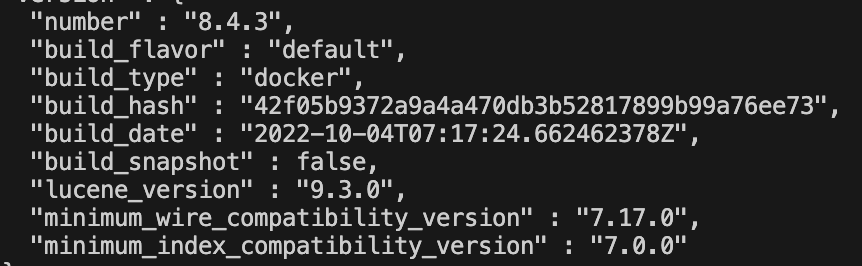m

### Answer:
- 42f05b9372a9a4a470db3b52817899b99a76ee73

## Getting the data


Now let's get the FAQ data. You can run this snippet:



In [2]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

Note that you need to have the requests library:
- pip install requests



In [3]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

## Q2. Indexing the data



Index the data in the same way as was shown in the course videos. Make the course field a keyword and the rest should be text.

Which function do you use for adding your data to elastic?

- insert
- index
- put
- add

In [4]:
from elasticsearch import Elasticsearch

In [14]:
es_client = Elasticsearch('http://localhost:9200') 

In [15]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = "course-questions"

es_client.indices.create(index=index_name, body=index_settings)

BadRequestError: BadRequestError(400, 'resource_already_exists_exception', 'index [course-questions/lwwNJMnfTSmX8oPznPyLng] already exists')

In [16]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

/usr/local/python/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:21<00:00, 44.60it/s]


### Answer:
- index

In [17]:
es_client

<Elasticsearch(['http://localhost:9200'])>

## Q3. Searching

Now let's search in our index.

We will execute a query "How do I execute a command in a running docker container?".

Use only question and text fields and give question a boost of 4, and use "type": "best_fields".

What's the score for the top ranking result?

#### Look at the _score field.



In [8]:
query = "How do I execute a command in a running docker container?"

In [ ]:
def search(query):
    boost = {'question': 4.0}

    results = index.search(
    query=query,
    filter_dict={'course':'data-engineering-zoomcamp'}, # type of filtering
    boost_dict=boost,
    num_results=5
    )

    return results

In [18]:
def elastic_search(query):
    boost = {'question': 4.0}

    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

In [19]:
elastic_search(query)

[{'text': 'In case running pgcli  locally causes issues or you do not want to install it locally you can use it running in a Docker container instead.\nBelow the usage with values used in the videos of the course for:\nnetwork name (docker network)\npostgres related variables for pgcli\nHostname\nUsername\nPort\nDatabase name\n$ docker run -it --rm --network pg-network ai2ys/dockerized-pgcli:4.0.1\n175dd47cda07:/# pgcli -h pg-database -U root -p 5432 -d ny_taxi\nPassword for root:\nServer: PostgreSQL 16.1 (Debian 16.1-1.pgdg120+1)\nVersion: 4.0.1\nHome: http://pgcli.com\nroot@pg-database:ny_taxi> \\dt\n+--------+------------------+-------+-------+\n| Schema | Name             | Type  | Owner |\n|--------+------------------+-------+-------|\n| public | yellow_taxi_data | table | root  |\n+--------+------------------+-------+-------+\nSELECT 1\nTime: 0.009s\nroot@pg-database:ny_taxi>',
  'section': 'Module 1: Docker and Terraform',
  'question': 'PGCLI - running in a Docker container',
 

In [21]:
result_docs._score()

NameError: name 'result_docs' is not defined